# 1) Setup and Configuration

In [27]:
import io
import os
import json
import pickle
import joblib
import warnings
import tempfile
import textwrap
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import matplotlib.dates as mdates

from scipy import stats
from tensorflow import keras
from datetime import datetime
from xgboost import XGBRegressor
from plotly.subplots import make_subplots
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import RobustScaler
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import GRU, Dense, Dropout, Input
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau

warnings.filterwarnings('ignore', category=UserWarning)

# initializing dictionaries to store models and predictions:
pm25_models = {}
pm25_scalers = {}
pm10_models_bytes = {}
pm10_scalers = {}
all_station_predictions = {}  # for PM2.5
all_station_predictions_pm10 = {}  # for PM10

# 2) Data Acquisition

In [28]:
!pip -q install gdown
import gdown

file_id = "1wNgF_aBtkGlFuvNsb5iu8P1nYbS9R4tT"
url = f"https://drive.google.com/uc?export=download&id={file_id}"
out_path = "AQI Dataset.csv"
gdown.download(url, out_path, quiet=False)

df = pd.read_csv(out_path, index_col=0)
df = df.drop(columns=["Unnamed: 0"], errors="ignore")

print(f"Dataset loaded: {len(df)} rows, {df.shape[1]} columns")
print(f"First 5 rows:")
df.head()

Downloading...
From: https://drive.google.com/uc?export=download&id=1wNgF_aBtkGlFuvNsb5iu8P1nYbS9R4tT
To: /content/AQI Dataset.csv
100%|██████████| 1.35M/1.35M [00:00<00:00, 12.9MB/s]

Dataset loaded: 19164 rows, 11 columns
First 5 rows:


,date,pm25,pm10,o3,no2,so2,station,year,month,season,year_month
0,2025-11-01,65.0,22.0,40.0,9.0,2.0,Bjelave,2025,11,Fall,2025-11
1,2025-11-02,58.0,12.0,40.0,10.0,1.0,Bjelave,2025,11,Fall,2025-11
2,2025-11-03,32.0,21.0,24.0,10.0,5.0,Bjelave,2025,11,Fall,2025-11
3,2025-11-04,60.0,33.0,17.0,14.0,3.0,Bjelave,2025,11,Fall,2025-11
4,2025-11-05,79.0,47.0,14.0,17.0,4.0,Bjelave,2025,11,Fall,2025-11


# 3) Data Preprocessing
Prepareing the dataset for time-series analysis by:
- converting date column to datetime format
- extracting unique station list for per-station modeling
- setting up column constants for consistent reference

In [29]:
DT_COL = "date"
STATION_COL = "station"

# creating station list (used in both PM2.5 and PM10 training):
stations = df["station"].unique().tolist()

print(f"Processing {len(stations)} unique stations:")
print(f"   {stations}")

# converting date column and sorting chronologically:
df[DT_COL] = pd.to_datetime(df[DT_COL], errors="coerce")
df = df.dropna(subset=[DT_COL]).copy()
df = df.sort_values(DT_COL).reset_index(drop=True)

print(f"\nDate range: {df[DT_COL].min()} to {df[DT_COL].max()}")
print(f"Station distribution:")
print(df[STATION_COL].value_counts())

Processing 7 unique stations:
   ['Bjelave', 'Otoka', 'Ilidza', 'Vijecnica', 'Ilijas', 'Ivan Sedlo', 'US Embassy']

Date range: 2016-11-07 00:00:00 to 2025-11-19 00:00:00
Station distribution:
station
Bjelave       3052
Otoka         3020
Ivan Sedlo    2885
Ilidza        2663
US Embassy    2570
Ilijas        2489
Vijecnica     2485
Name: count, dtype: int64


# 4) Feature Selection
Identifing the target variable (PM2.5) and feature columns for the XGBoost model.
Only numeric columns are selected to ensure compatibility with scikit-learn.



In [30]:
TARGET_COLS = ["pm25"]

# selecting only numeric features (excludes strings like season/year_month/station)
numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
feature_cols = numeric_cols  # using all numeric columns as features

print(f"Target variable: {TARGET_COLS}")
print(f"Feature columns ({len(feature_cols)} total):")
print(feature_cols)

Target variable: ['pm25']
Feature columns (7 total):
['pm25', 'pm10', 'o3', 'no2', 'so2', 'year', 'month']


# 5) Time Series Utilities
Creating time-series sequences for model training.
This function converts tabular data into supervised learning format
with specified lookback window and prediction horizon.

In [31]:
def make_sequences(X, y, lookback=7, horizon=1):
    """
    Parameters:
    -----------
    X : array-like, feature matrix
    y : array-like, target values
    lookback : int, number of historical time steps to use as input
    horizon : int, number of future time steps to predict

    Returns:
    --------
    Xs, ys : arrays of sequences and corresponding targets
    """
    Xs, ys = [], []
    N = len(X)
    for i in range(N - lookback - horizon + 1):
        Xs.append(X[i:i+lookback])
        target_slice = y[i+lookback:i+lookback+horizon]
        ys.append(target_slice[0] if horizon == 1 else target_slice)
    return np.array(Xs), np.array(ys)

LOOKBACK = 7
HORIZON = 1

print(f"Sequence parameters: Lookback={LOOKBACK}, Horizon={HORIZON}")
print("make_sequences function defined")

Sequence parameters: Lookback=7, Horizon=1
make_sequences function defined


# 6) **PM2.5**

## 6.1 Modeling: XGBoost Training Pipeline
Training XGBoost models for PM2.5 prediction for each station.
This cell:
1. separates data by station
2. creates time-based splits (70/15/15)
3. scales features and targets
4. generates sequences for supervised learning
5. trains XGBoost with optimized hyperparameters
6. stores models, scalers, and predictions

In [32]:
print(f"Starting PM2.5 (XGBoost) training for {len(stations)} stations")
print("=" * 60)

for station in stations:
    print(f"\n{'─' * 40}")
    print(f"-> Processing station: {station}")
    print(f"{'─' * 40}")

    # 1. filtering data for current station
    station_df = df[df[STATION_COL] == station].copy()

    # 2. time-aware split (70% train, 15% validation, 15% test)
    n = len(station_df)
    train_end = int(n * 0.70)
    val_end = int(n * 0.85)

    train_df = station_df.iloc[:train_end].copy()
    val_df = station_df.iloc[train_end:val_end].copy()
    test_df = station_df.iloc[val_end:].copy()

    print(f"Data split: Train={len(train_df)}, Val={len(val_df)}, Test={len(test_df)}")

    # 3. scaling features and targets
    X_scaler = StandardScaler()
    y_scaler = StandardScaler()

    X_train = X_scaler.fit_transform(train_df[feature_cols].values)
    X_val = X_scaler.transform(val_df[feature_cols].values)
    X_test = X_scaler.transform(test_df[feature_cols].values)

    y_train = y_scaler.fit_transform(train_df[TARGET_COLS].values)
    y_val = y_scaler.transform(val_df[TARGET_COLS].values)
    y_test = y_scaler.transform(test_df[TARGET_COLS].values)

    # 4. creating time-series sequences
    Xtr, ytr = make_sequences(X_train, y_train, lookback=LOOKBACK, horizon=HORIZON)
    Xva, yva = make_sequences(X_val, y_val, lookback=LOOKBACK, horizon=HORIZON)
    Xte, yte = make_sequences(X_test, y_test, lookback=LOOKBACK, horizon=HORIZON)

    if len(Xte) == 0 or len(Xva) == 0:
        print(f"   Not enough sequences for {station}, skipping...")
        continue

    # 5. training XGBoost model
    model = XGBRegressor(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )

    model.fit(Xtr.reshape(Xtr.shape[0], -1), ytr)

    # 6. making predictions on TEST set
    y_test_pred_scaled = model.predict(Xte.reshape(Xte.shape[0], -1))
    y_test_true_scaled = yte

    y_test_pred_original = y_scaler.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).flatten()
    y_test_true_original = y_scaler.inverse_transform(y_test_true_scaled.reshape(-1, 1)).flatten()

    # 7. making predictions on VALIDATION set
    y_val_pred_scaled = model.predict(Xva.reshape(Xva.shape[0], -1))
    y_val_true_scaled = yva

    y_val_pred_original = y_scaler.inverse_transform(y_val_pred_scaled.reshape(-1, 1)).flatten()
    y_val_true_original = y_scaler.inverse_transform(y_val_true_scaled.reshape(-1, 1)).flatten()

    # 8. calculating performance metrics
    test_mae = mean_absolute_error(y_test_true_original, y_test_pred_original)
    test_rmse = np.sqrt(mean_squared_error(y_test_true_original, y_test_pred_original))
    test_r2 = r2_score(y_test_true_original, y_test_pred_original)

    val_mae = mean_absolute_error(y_val_true_original, y_val_pred_original)
    val_rmse = np.sqrt(mean_squared_error(y_val_true_original, y_val_pred_original))
    val_r2 = r2_score(y_val_true_original, y_val_pred_original)

    print(f"Test Metrics:  MAE={test_mae:.3f}, RMSE={test_rmse:.3f}, R²={test_r2:.3f}")
    print(f"Val Metrics:   MAE={val_mae:.3f}, RMSE={val_rmse:.3f}, R²={val_r2:.3f}")

    # 9. storing model and scalers in dictionaries
    pm25_models[station] = model
    pm25_scalers[station] = (X_scaler, y_scaler)

    # 10. saving individual files
    # saveing PM2.5 model:
    model.save_model(f"pm25_model_{station}.json")
    print(f"Saved: pm25_model_{station}.json")

    # saving PM2.5 scalers:
    scaler_data = {
        'X_scaler': X_scaler,
        'y_scaler': y_scaler
    }
    joblib.dump(scaler_data, f"pm25_scaler_{station}.pkl")
    print(f"Saved: pm25_scaler_{station}.pkl")

    # 11. storing predictions
    test_dates = []
    if len(test_df) > LOOKBACK + len(y_test_pred_original):
        test_dates = test_df['date'].iloc[LOOKBACK:LOOKBACK+len(y_test_pred_original)].values.tolist()
    else:
        test_dates = test_df['date'].iloc[-len(y_test_pred_original):].values.tolist()

    val_dates = []
    if len(val_df) > LOOKBACK + len(y_val_pred_original):
        val_dates = val_df['date'].iloc[LOOKBACK:LOOKBACK+len(y_val_pred_original)].values.tolist()
    else:
        val_dates = val_df['date'].iloc[-len(y_val_pred_original):].values.tolist()

    all_station_predictions[station] = {
        'test_predictions': y_test_pred_original.tolist(),
        'test_true': y_test_true_original.tolist(),
        'test_dates': test_dates,

        'validation_predictions': y_val_pred_original.tolist(),
        'validation_true': y_val_true_original.tolist(),
        'validation_dates': val_dates,

        'test_mae': float(test_mae),
        'test_rmse': float(test_rmse),
        'test_r2': float(test_r2),
        'val_mae': float(val_mae),
        'val_rmse': float(val_rmse),
        'val_r2': float(val_r2),

        'model_type': 'XGBoost',
        'lookback': LOOKBACK,
        'horizon': HORIZON
    }

    print(f"Saved {len(y_test_pred_original)} test predictions")
    print(f"Saved {len(y_val_pred_original)} validation predictions")

print(f"\nPM2.5 training completed for {len(pm25_models)} stations")
print(f"Total predictions stored: {sum(len(preds['test_predictions']) + len(preds['validation_predictions']) for preds in all_station_predictions.values()):,} values")

Starting PM2.5 (XGBoost) training for 7 stations

────────────────────────────────────────
-> Processing station: Bjelave
────────────────────────────────────────
Data split: Train=2136, Val=458, Test=458
Test Metrics:  MAE=10.491, RMSE=16.018, R²=0.883
Val Metrics:   MAE=7.798, RMSE=11.212, R²=0.891
Saved: pm25_model_Bjelave.json
Saved: pm25_scaler_Bjelave.pkl
Saved 451 test predictions
Saved 451 validation predictions

────────────────────────────────────────
-> Processing station: Otoka
────────────────────────────────────────
Data split: Train=2114, Val=453, Test=453
Test Metrics:  MAE=12.396, RMSE=18.376, R²=0.891
Val Metrics:   MAE=11.974, RMSE=16.792, R²=0.867
Saved: pm25_model_Otoka.json
Saved: pm25_scaler_Otoka.pkl
Saved 446 test predictions
Saved 446 validation predictions

────────────────────────────────────────
-> Processing station: Ilidza
────────────────────────────────────────
Data split: Train=1864, Val=399, Test=400
Test Metrics:  MAE=7.468, RMSE=10.456, R²=0.952
Val

# 7) **PM10**

## 7.1 Feature Engineering
Creating specialized features for PM10 prediction including:
- time-lagged features (lag1, lag7)
- rolling statistics
- cyclical date encoding


These features are designed to capture temporal patterns and seasonality.

In [33]:
def add_time_series_history(df):
    df = df.sort_values(['station', 'date'])

    # calculating lags and rolling means per station:
    df['pm25_lag1'] = df.groupby('station')['pm25'].shift(1)
    df['pm25_lag7'] = df.groupby('station')['pm25'].shift(7)
    df['pm25_roll7_mean'] = df.groupby('station')['pm25'].transform(
        lambda x: x.rolling(window=7, min_periods=1).mean()
    )

    return df.dropna()

def engineer_features_pm10(df_station, clip_pm10=True):
    d = df_station.copy()
    d["date"] = pd.to_datetime(d["date"])

    # clipping extreme outliers:
    if clip_pm10:
        d["pm10"] = d["pm10"].clip(0, 300)

    # cyclical day-of-year features for seasonality:
    d['doy_sin'] = np.sin(2 * np.pi * d['date'].dt.dayofyear / 365.25)
    d['doy_cos'] = np.cos(2 * np.pi * d['date'].dt.dayofyear / 365.25)
    d['o3_inverse'] = 1 / (d['o3'] + 1)

    features = [
        "pm25", "o3", "no2", "so2", "pm10",
        "pm25_lag1", "pm25_lag7", "pm25_roll7_mean",
        "doy_sin", "doy_cos", "o3_inverse"
    ]
    return d, features

print("PM10 feature engineering functions defined")
print("   - add_time_series_history: Adds lag and rolling features")
print("   - engineer_features_pm10: Creates cyclical and derived features")

PM10 feature engineering functions defined
   - add_time_series_history: Adds lag and rolling features
   - engineer_features_pm10: Creates cyclical and derived features


## 7.2 Sequence Generation
Implementing the advanced log-residual approach for PM10 sequence creation by:
1. appling log transformation for variance stabilization
2. predicting residuals relative to last observed value
3. creating sequences with 30-day lookback and 7-day horizon
This approach improves model stability and accuracy.

In [34]:
def make_sequences_pm10_v3(df_station, features, seq_len=30, horizon=7):
    """
    Parameters:
    -----------
    df_station : DataFrame, station-specific data
    features : list, feature column names
    seq_len : int, sequence length (lookback period)
    horizon : int, prediction horizon (days ahead)

    Returns:
    --------
    X_all : sequences of features
    y_all : residual targets (log scale)
    last_all : last observed values for reconstruction
    """
    X_all, y_all, last_all = [], [], []
    Xmat = df_station[features].values
    yvec_log = np.log1p(df_station["pm10"].values)  # Log-transform for variance stability

    for i in range(len(df_station) - seq_len - horizon):
        X_seq = Xmat[i:i+seq_len]
        last_val_log = yvec_log[i+seq_len-1]
        future_log = yvec_log[i+seq_len:i+seq_len+horizon]
        y_residual = future_log - last_val_log

        if np.isnan(X_seq).any() or np.isnan(y_residual).any():
            continue

        X_all.append(X_seq)
        y_all.append(y_residual)
        last_all.append(last_val_log)

    return np.array(X_all), np.array(y_all), np.array(last_all)

print("PM10 sequence generation function defined")
print("   - Log transformation for variance stabilization")
print("   - Residual-based target formulation")
print("   - 30-day lookback, 7-day horizon")

PM10 sequence generation function defined
   - Log transformation for variance stabilization
   - Residual-based target formulation
   - 30-day lookback, 7-day horizon


## 7.3 GRU Architecture
Defining the GRU neural network architecture for PM10 prediction with:
- two GRU layers with dropout regularization
- L2 regularization to prevent overfitting
- Huber loss for robustness to outliers
- custom callback for RMSE monitoring

In [35]:
def build_pm10_gru_v3(input_shape):
    """
    Parameters:
    -----------
    input_shape : tuple, (sequence_length, num_features)

    Returns:
    --------
    model : Compiled Keras Sequential model
    """
    model = Sequential([
        Input(shape=input_shape),
        GRU(64, return_sequences=True),
        Dropout(0.4),
        GRU(32),
        Dropout(0.3),
        Dense(32, activation="relu", kernel_regularizer=l2(0.01)),
        Dense(7)
    ])
    model.compile(optimizer=Adam(learning_rate=5e-4), loss=Huber())
    return model

class PM10RMSECallback(Callback):
    def __init__(self, X_val, y_val, last_val):
        super().__init__()
        self.X_val = X_val
        self.y_val = y_val
        self.last_val = last_val
        self.rmse_history = []
        self.best_rmse = np.inf
        self.best_weights = None

    def on_epoch_end(self, epoch, logs=None):
        y_pred_res = self.model.predict(self.X_val, verbose=0)
        y_pred = np.expm1(self.last_val.reshape(-1,1) + y_pred_res)
        y_true = np.expm1(self.last_val.reshape(-1,1) + self.y_val)
        rmse_day1 = np.sqrt(mean_squared_error(y_true[:,0], y_pred[:,0]))
        self.rmse_history.append(rmse_day1)
        if rmse_day1 < self.best_rmse:
            self.best_rmse = rmse_day1
            self.best_weights = self.model.get_weights()

print("GRU model architecture and callbacks defined")
print("   - 2-layer GRU with dropout regularization")
print("   - Custom RMSE monitoring callback")
print("   - Huber loss for outlier robustness")

GRU model architecture and callbacks defined
   - 2-layer GRU with dropout regularization
   - Custom RMSE monitoring callback
   - Huber loss for outlier robustness


In [36]:
def generate_advanced_report(y_true, y_pred, last_values, station_name):
    report_data = []

    for day in range(y_pred.shape[1]):
        day_true = y_true[:, day]
        day_pred = y_pred[:, day]

        # calculating metrics:
        rmse = np.sqrt(mean_squared_error(day_true, day_pred))
        mae = mean_absolute_error(day_true, day_pred)
        r2 = r2_score(day_true, day_pred)

        # calculating skill score (vs persistence baseline):
        persistence_pred = last_values
        persistence_rmse = np.sqrt(mean_squared_error(day_true, persistence_pred))
        skill_score = 1 - (rmse / persistence_rmse) if persistence_rmse > 0 else 0

        # calculating hit rate (within 20% of true value):
        hit_rate = np.mean(np.abs((day_pred - day_true) / (day_true + 1e-10)) <= 0.2) * 100

        report_data.append({
            'Station': station_name,
            'Day': day + 1,
            'RMSE': rmse,
            'MAE': mae,
            'R2': r2,
            'Skill_Score': skill_score,
            'Hit_Rate': hit_rate
        })

    return pd.DataFrame(report_data)

def plot_all_persistence(all_reports_list):
    plt.figure(figsize=(12, 6))

    for report in all_reports_list:
        plt.plot(report['Day'], report['RMSE'], marker='o', label=f"{report['Station'].iloc[0]}")

    plt.title("Model RMSE vs. Forecast Horizon (7 Days)")
    plt.xlabel("Days Ahead")
    plt.ylabel("Error (RMSE)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.2)
    plt.savefig("all_stations_rmse_trend.png", bbox_inches='tight')
    plt.show()
    print("Saved: all_stations_rmse_trend.png")

## 7.4 Training: GRU Model Pipeline
Training GRU models for PM10 prediction using the log-residual approach.
Each station receives a dedicated model with:
- advanced feature engineering
- robust scaling
- early stopping and learning rate reduction
- performance tracking and visualization

In [37]:
print(f"Starting PM10 (GRU) training for {len(stations)} stations")
print("=" * 60)

# FIRST: add time series history features to the entire dataframe:
df_with_history = add_time_series_history(df.copy())

for station in stations:
    print(f"\n{'─' * 40}")
    print(f"-> Processing station: {station} (PM10)")
    print(f"{'─' * 40}")

    # filtering data for current station (from the dataframe with history):
    station_df = df_with_history[df_with_history[STATION_COL] == station].copy()

    # engineering PM10-specific features:
    station_df, features = engineer_features_pm10(station_df)

    # checking if all required features exist:
    missing_features = [f for f in features if f not in station_df.columns]
    if missing_features:
        print(f"Missing features {missing_features}, skipping...")
        continue

    # creating sequences using log-residual approach:
    Xs, ys, lasts = make_sequences_pm10_v3(station_df, features, seq_len=30, horizon=7)

    if len(Xs) == 0:
        print(f"Insufficient data for {station}, skipping...")
        continue

    # scaling features using RobustScaler:
    scaler = RobustScaler()
    Xs_scaled = scaler.fit_transform(Xs.reshape(-1, len(features))).reshape(Xs.shape)

    # splitting data (80/20 train/validation):
    split = int(len(Xs) * 0.8)
    X_train, X_val = Xs_scaled[:split], Xs_scaled[split:]
    y_train, y_val = ys[:split], ys[split:]
    last_val_split = lasts[split:]

    # getting dates for validation set:
    val_dates = []
    if len(station_df) > split + 30 + len(y_val):
        date_indices = list(range(split + 30, split + 30 + len(y_val)))
        val_dates = station_df['date'].iloc[date_indices].values.tolist()
    else:
        val_dates = station_df['date'].iloc[-len(y_val):].values.tolist()

    # building and compiling GRU model:
    model = build_pm10_gru_v3((Xs.shape[1], Xs.shape[2]))

    callbacks = [
        PM10RMSECallback(X_val, y_val, last_val_split),
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=0)
    ]

    # training the model:
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=150,
        batch_size=32,
        callbacks=callbacks,
        verbose=0
    )

    # making predictions on validation set:
    y_pred_res = model.predict(X_val, verbose=0)

    # reconstructing predictions from residuals:
    y_pred = np.expm1(last_val_split.reshape(-1,1) + y_pred_res)
    y_true = np.expm1(last_val_split.reshape(-1,1) + y_val)

    # calculating metrics for each forecast horizon:
    test_mae = mean_absolute_error(y_true[:,0], y_pred[:,0])
    test_rmse = np.sqrt(mean_squared_error(y_true[:,0], y_pred[:,0]))
    test_r2 = r2_score(y_true[:,0], y_pred[:,0])

    print(f"  Day 1 Forecast Metrics:")
    print(f"     MAE={test_mae:.3f}, RMSE={test_rmse:.3f}, R²={test_r2:.3f}")

    # saving PM10 model as .keras file:
    model.save(f"pm10_model_{station}.keras")
    print(f"  Saved: pm10_model_{station}.keras")

    # saving PM10 scaler as .pkl file:
    joblib.dump(scaler, f"pm10_scaler_{station}.pkl")
    print(f"  Saved: pm10_scaler_{station}.pkl")

    # also saving model as bytes for serialization in the combined package:
    with tempfile.NamedTemporaryFile(suffix='.keras', delete=False) as tmp:
        model.save(tmp.name)
        with open(tmp.name, 'rb') as f:
            model_bytes = f.read()
        os.unlink(tmp.name)

    pm10_models_bytes[station] = model_bytes
    pm10_scalers[station] = scaler

    station_report = []
    for day in range(7):
        day_rmse = np.sqrt(mean_squared_error(y_true[:, day], y_pred[:, day]))
        day_mae = mean_absolute_error(y_true[:, day], y_pred[:, day])
        persistence_rmse = np.sqrt(mean_squared_error(y_true[:, day], np.full_like(y_pred[:, day], y_pred[0, 0])))
        skill_score = 1 - (day_rmse / persistence_rmse) if persistence_rmse > 0 else 0

        station_report.append({
            'Station': station,
            'Day': day + 1,
            'RMSE': day_rmse,
            'MAE': day_mae,
            'Skill_Score': skill_score,
            'Hit_Rate': np.mean((y_pred[:, day] <= 50) == (y_true[:, day] <= 50)) * 100
        })

    station_report_df = pd.DataFrame(station_report)
    station_report_df.to_csv(f"pm10_audit_{station}.csv", index=False)
    print(f"   Saved: pm10_audit_{station}.csv")

    # plotting loss curves:
    plt.figure(figsize=(10,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f"{station} - Loss Curves")
    plt.legend()
    plt.savefig(f"loss_curves_{station}.png")
    plt.close()
    print(f"   Saved: loss_curves_{station}.png")

    all_station_predictions_pm10[station] = {
        'test_predictions': y_pred.tolist(),
        'test_true': y_true.tolist(),
        'test_dates': val_dates,
        'last_values': last_val_split.tolist(),
        'test_mae': float(test_mae),
        'test_rmse': float(test_rmse),
        'test_r2': float(test_r2),
        'model_type': 'GRU',
        'lookback': 30,
        'horizon': 7,
        'forecast_days': list(range(1, 8))
    }

    print(f"   Saved {len(y_pred)} forecast sequences (each with 7-day predictions)")
    print(f"   Total prediction values: {len(y_pred) * 7:,}")

print(f"\nPM10 training completed for {len(pm10_models_bytes)} stations")
print(f"Total 7-day forecasts stored: {sum(len(preds['test_predictions']) * 7 for preds in all_station_predictions_pm10.values()):,} values")

print("\nCreating master audit report...")
all_audit_files = [f for f in os.listdir('.') if f.startswith('pm10_audit_') and f.endswith('.csv')]
if all_audit_files:
    all_reports = []
    for audit_file in all_audit_files:
        station_df = pd.read_csv(audit_file)
        all_reports.append(station_df)

    if all_reports:
        master_audit = pd.concat(all_reports, ignore_index=True)
        master_audit.to_csv("sarajevo_all_stations_audit.csv", index=False)
        print(f"Master audit saved: sarajevo_all_stations_audit.csv")

        print("\n" + "="*50)
        print("DAY 1 ACCURACY")
        print("="*50)
        day1_stats = master_audit[master_audit['Day'] == 1].sort_values(by='RMSE')
        print(day1_stats[['Station', 'RMSE', 'Skill_Score', 'Hit_Rate']].to_string(index=False))

Starting PM10 (GRU) training for 7 stations

────────────────────────────────────────
-> Processing station: Bjelave (PM10)
────────────────────────────────────────
  Day 1 Forecast Metrics:
     MAE=8.388, RMSE=15.062, R²=0.539
  Saved: pm10_model_Bjelave.keras
  Saved: pm10_scaler_Bjelave.pkl
   Saved: pm10_audit_Bjelave.csv
   Saved: loss_curves_Bjelave.png
   Saved 602 forecast sequences (each with 7-day predictions)
   Total prediction values: 4,214

────────────────────────────────────────
-> Processing station: Otoka (PM10)
────────────────────────────────────────
  Day 1 Forecast Metrics:
     MAE=10.395, RMSE=16.940, R²=0.599
  Saved: pm10_model_Otoka.keras
  Saved: pm10_scaler_Otoka.pkl
   Saved: pm10_audit_Otoka.csv
   Saved: loss_curves_Otoka.png
   Saved 596 forecast sequences (each with 7-day predictions)
   Total prediction values: 4,172

────────────────────────────────────────
-> Processing station: Ilidza (PM10)
────────────────────────────────────────
  Day 1 Forecas

# 8) Comprehensive Results Report:

In [38]:
# calculating best performing stations:
best_pm25_station = None
best_pm25_r2 = -1
best_pm10_station = None
best_pm10_r2 = -1

# finding best PM2.5 station:
for station in stations:
    if station in all_station_predictions:
        r2 = all_station_predictions[station]['test_r2']
        if r2 > best_pm25_r2:
            best_pm25_r2 = r2
            best_pm25_station = station

# finding best PM10 station:
for station in stations:
    if station in all_station_predictions_pm10:
        r2 = all_station_predictions_pm10[station]['test_r2']
        if r2 > best_pm10_r2:
            best_pm10_r2 = r2
            best_pm10_station = station

print(f"Best PM2.5 station: {best_pm25_station} (R² = {best_pm25_r2:.3f})")
print(f"Best PM10 station: {best_pm10_station} (R² = {best_pm10_r2:.3f})")

Best PM2.5 station: Ilidza (R² = 0.952)
Best PM10 station: Ilidza (R² = 0.639)


In [39]:
# creating a comprehensive markdown report:
report_date = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
total_records = len(df)
total_models = len(pm25_models) + len(pm10_models_bytes)

# calculating overall statistics:
pm25_r2_values = [all_station_predictions[station]['test_r2'] for station in stations if station in all_station_predictions]
pm10_r2_values = [all_station_predictions_pm10[station]['test_r2'] for station in stations if station in all_station_predictions_pm10]

avg_pm25_r2 = np.mean(pm25_r2_values) if pm25_r2_values else 0
avg_pm10_r2 = np.mean(pm10_r2_values) if pm10_r2_values else 0

# creating a markdown report:
report_content = f"""# Air Quality Prediction Model Results Report

## Executive Summary
- **Report Generated**: {report_date}
- **Total Stations**: {len(stations)}
- **Total Models Trained**: {total_models} (PM2.5: {len(pm25_models)}, PM10: {len(pm10_models_bytes)})
- **Dataset Records**: {total_records:,}
- **Date Range**: {df['date'].min().strftime('%Y-%m-%d')} to {df['date'].max().strftime('%Y-%m-%d')}

## Performance Overview

### Model Architecture
| Model | Algorithm | Lookback | Horizon | Features | Key Parameters |
|-------|-----------|----------|---------|----------|----------------|
| PM2.5 | XGBoost | 7 days | 1 day | 8 numeric | n_estimators=100, max_depth=5 |
| PM10 | GRU | 30 days | 7 days | 11 engineered | 2-layer GRU (64→32 units) |

### Overall Performance Metrics
| Pollutant | Average R² | Best Station | Best R² | Average RMSE |
|-----------|------------|--------------|---------|--------------|
| PM2.5 | {avg_pm25_r2:.3f} | {best_pm25_station} | {best_pm25_r2:.3f} | {np.mean([all_station_predictions[s]['test_rmse'] for s in stations if s in all_station_predictions]):.1f} |
| PM10 | {avg_pm10_r2:.3f} | {best_pm10_station} | {best_pm10_r2:.3f} | {np.mean([all_station_predictions_pm10[s]['test_rmse'] for s in stations if s in all_station_predictions_pm10]):.1f} |

## Detailed Station Performance

### PM2.5 (XGBoost) Models
| Station | Test R² | Test RMSE | Test MAE | Validation R² |
|---------|---------|-----------|----------|---------------|
"""

# adding PM2.5 station performance:
for station in stations:
    if station in all_station_predictions:
        data = all_station_predictions[station]
        report_content += f"| {station} | {data['test_r2']:.3f} | {data['test_rmse']:.2f} | {data['test_mae']:.2f} | {data['val_r2']:.3f} |\n"

report_content += f"""
### PM10 (GRU) Models
| Station | Test R² | Test RMSE | Test MAE | Forecast Horizon |
|---------|---------|-----------|----------|------------------|
"""

# adding PM10 station performance:
for station in stations:
    if station in all_station_predictions_pm10:
        data = all_station_predictions_pm10[station]
        report_content += f"| {station} | {data['test_r2']:.3f} | {data['test_rmse']:.2f} | {data['test_mae']:.2f} | 7 days |\n"

report_content += f"""
## Model Insights

### Top Performing Stations
1. **Best PM2.5**: {best_pm25_station} (R² = {best_pm25_r2:.3f})
2. **Best PM10**: {best_pm10_station} (R² = {best_pm10_r2:.3f})

### Performance Categories
- **Excellent** (R² > 0.9): {', '.join([s for s in stations if s in all_station_predictions and all_station_predictions[s]['test_r2'] > 0.9])}
- **Good** (0.8 < R² ≤ 0.9): {', '.join([s for s in stations if s in all_station_predictions and 0.8 < all_station_predictions[s]['test_r2'] <= 0.9])}
- **Moderate** (R² ≤ 0.8): {', '.join([s for s in stations if s in all_station_predictions and all_station_predictions[s]['test_r2'] <= 0.8])}

## Dataset Statistics

### Station Data Distribution
"""

# adding station distribution:
station_counts = df['station'].value_counts()
for station, count in station_counts.items():
    percentage = (count / total_records) * 100
    report_content += f"- **{station}**: {count:,} records ({percentage:.1f}%)\n"

report_content += f"""
### Temporal Coverage
- **Years**: {df['date'].dt.year.min()} - {df['date'].dt.year.max()}
- **Months**: All 12 months represented
- **Seasons**: {', '.join(df['season'].unique().tolist())}

### Feature Statistics
"""

# adding feature statistics:
numeric_features = ['pm25', 'pm10', 'o3', 'no2', 'so2']
for feature in numeric_features:
    if feature in df.columns:
        mean_val = df[feature].mean()
        std_val = df[feature].std()
        min_val = df[feature].min()
        max_val = df[feature].max()
        report_content += f"- **{feature.upper()}**: Mean = {mean_val:.1f}, Std = {std_val:.1f}, Range = [{min_val:.1f}, {max_val:.1f}]\n"

with open('model_results_report.md', 'w') as f:
    f.write(report_content)

from IPython.display import display, Markdown
display(Markdown(report_content))

print("\n" + "="*60)
print("QUICK PERFORMANCE SUMMARY")
print("="*60)

print(f"\nOVERALL PERFORMANCE:")
print(f"   PM2.5 Average R²: {avg_pm25_r2:.3f}")
print(f"   PM10 Average R²:  {avg_pm10_r2:.3f}")

print(f"\nBEST PERFORMING STATIONS:")
print(f"   PM2.5: {best_pm25_station} (R² = {best_pm25_r2:.3f})")
print(f"   PM10:  {best_pm10_station} (R² = {best_pm10_r2:.3f})")

print(f"\nSTATION RANKING (PM2.5):")
sorted_stations = sorted([(s, all_station_predictions[s]['test_r2'])
                         for s in stations if s in all_station_predictions],
                         key=lambda x: x[1], reverse=True)

for i, (station, r2) in enumerate(sorted_stations, 1):
    performance = ""
    if r2 > 0.9:
        performance = " [Excellent]"
    elif r2 > 0.8:
        performance = " [Good]"
    else:
        performance = " [Moderate]"
    print(f"   {i}. {station}: R² = {r2:.3f}{performance}")

print(f"\nFILES GENERATED:")
print(f"   • Model Results Report: model_results_report.md")
print(f"   • JSON Summary: model_performance_summary.json")
print(f"   • Dashboard: air_quality_performance_dashboard.png")
print(f"   • Combined Package: air_quality_complete.pkl")

print(f"\nReport generation complete!")
print("="*60)

# Air Quality Prediction Model Results Report

## Executive Summary
- **Report Generated**: 2026-01-19 10:01:16
- **Total Stations**: 7
- **Total Models Trained**: 14 (PM2.5: 7, PM10: 7)
- **Dataset Records**: 19,164
- **Date Range**: 2016-11-07 to 2025-11-19

## Performance Overview

### Model Architecture
| Model | Algorithm | Lookback | Horizon | Features | Key Parameters |
|-------|-----------|----------|---------|----------|----------------|
| PM2.5 | XGBoost | 7 days | 1 day | 8 numeric | n_estimators=100, max_depth=5 |
| PM10 | GRU | 30 days | 7 days | 11 engineered | 2-layer GRU (64→32 units) |

### Overall Performance Metrics
| Pollutant | Average R² | Best Station | Best R² | Average RMSE |
|-----------|------------|--------------|---------|--------------|
| PM2.5 | 0.843 | Ilidza | 0.952 | 19.2 |
| PM10 | 0.453 | Ilidza | 0.639 | 19.7 |

## Detailed Station Performance

### PM2.5 (XGBoost) Models
| Station | Test R² | Test RMSE | Test MAE | Validation R² |
|---------|---------|-----------|----------|---------------|
| Bjelave | 0.883 | 16.02 | 10.49 | 0.891 |
| Otoka | 0.891 | 18.38 | 12.40 | 0.867 |
| Ilidza | 0.952 | 10.46 | 7.47 | 0.941 |
| Vijecnica | 0.854 | 18.62 | 12.73 | 0.807 |
| Ilijas | 0.777 | 27.70 | 19.07 | 0.788 |
| Ivan Sedlo | 0.695 | 24.86 | 15.40 | 0.601 |
| US Embassy | 0.848 | 18.08 | 13.03 | 0.549 |

### PM10 (GRU) Models
| Station | Test R² | Test RMSE | Test MAE | Forecast Horizon |
|---------|---------|-----------|----------|------------------|
| Bjelave | 0.539 | 15.06 | 8.39 | 7 days |
| Otoka | 0.599 | 16.94 | 10.40 | 7 days |
| Ilidza | 0.639 | 13.28 | 8.14 | 7 days |
| Vijecnica | 0.194 | 39.24 | 13.85 | 7 days |
| Ilijas | 0.527 | 17.51 | 10.73 | 7 days |
| Ivan Sedlo | 0.101 | 20.60 | 7.65 | 7 days |
| US Embassy | 0.571 | 15.26 | 8.76 | 7 days |

## Model Insights

### Top Performing Stations
1. **Best PM2.5**: Ilidza (R² = 0.952)
2. **Best PM10**: Ilidza (R² = 0.639)

### Performance Categories
- **Excellent** (R² > 0.9): Ilidza
- **Good** (0.8 < R² ≤ 0.9): Bjelave, Otoka, Vijecnica, US Embassy
- **Moderate** (R² ≤ 0.8): Ilijas, Ivan Sedlo

## Dataset Statistics

### Station Data Distribution
- **Bjelave**: 3,052 records (15.9%)
- **Otoka**: 3,020 records (15.8%)
- **Ivan Sedlo**: 2,885 records (15.1%)
- **Ilidza**: 2,663 records (13.9%)
- **US Embassy**: 2,570 records (13.4%)
- **Ilijas**: 2,489 records (13.0%)
- **Vijecnica**: 2,485 records (13.0%)

### Temporal Coverage
- **Years**: 2016 - 2025
- **Months**: All 12 months represented
- **Seasons**: Fall, Winter, Spring, Summer

### Feature Statistics
- **PM25**: Mean = 79.3, Std = 51.8, Range = [7.0, 484.0]
- **PM10**: Mean = 32.9, Std = 34.7, Range = [1.0, 880.0]
- **O3**: Mean = 30.5, Std = 17.3, Range = [1.0, 324.0]
- **NO2**: Mean = 10.3, Std = 7.7, Range = [1.0, 74.0]
- **SO2**: Mean = 8.9, Std = 9.0, Range = [1.0, 103.0]



QUICK PERFORMANCE SUMMARY

OVERALL PERFORMANCE:
   PM2.5 Average R²: 0.843
   PM10 Average R²:  0.453

BEST PERFORMING STATIONS:
   PM2.5: Ilidza (R² = 0.952)
   PM10:  Ilidza (R² = 0.639)

STATION RANKING (PM2.5):
   1. Ilidza: R² = 0.952 [Excellent]
   2. Otoka: R² = 0.891 [Good]
   3. Bjelave: R² = 0.883 [Good]
   4. Vijecnica: R² = 0.854 [Good]
   5. US Embassy: R² = 0.848 [Good]
   6. Ilijas: R² = 0.777 [Moderate]
   7. Ivan Sedlo: R² = 0.695 [Moderate]

FILES GENERATED:
   • Model Results Report: model_results_report.md
   • JSON Summary: model_performance_summary.json
   • Dashboard: air_quality_performance_dashboard.png
   • Combined Package: air_quality_complete.pkl

Report generation complete!


# 9) Comprehensive Visualization Dashboard
1. Model Performance Comparison - Bar chart comparing PM2.5 vs PM10 R² scores
2. Error Metrics Heatmap - Color-coded performance metrics across stations
3. Time Series Predictions - Actual vs predicted values for best station
4. Scatter Plot Analysis - Correlation between actual and predicted values
5. Error Distribution - Histogram with statistics of prediction errors
6. Forecast Horizon Analysis - How PM10 accuracy changes over 7 days
7. Seasonal Pattern Analysis - Monthly pollution trends
8. Station Performance Ranking - Horizontal bar chart ranking stations
9. Feature Importance - Most important features for predictions
10. Summary Metrics Table - Detailed performance metrics for all stations
11. Model Architecture - Technical specifications of both models
12. Key Insights & Recommendations - Actionable insights from analysis

Plot 1/12: Performance Comparison...
Generated: dashboard_performance_comparison.png


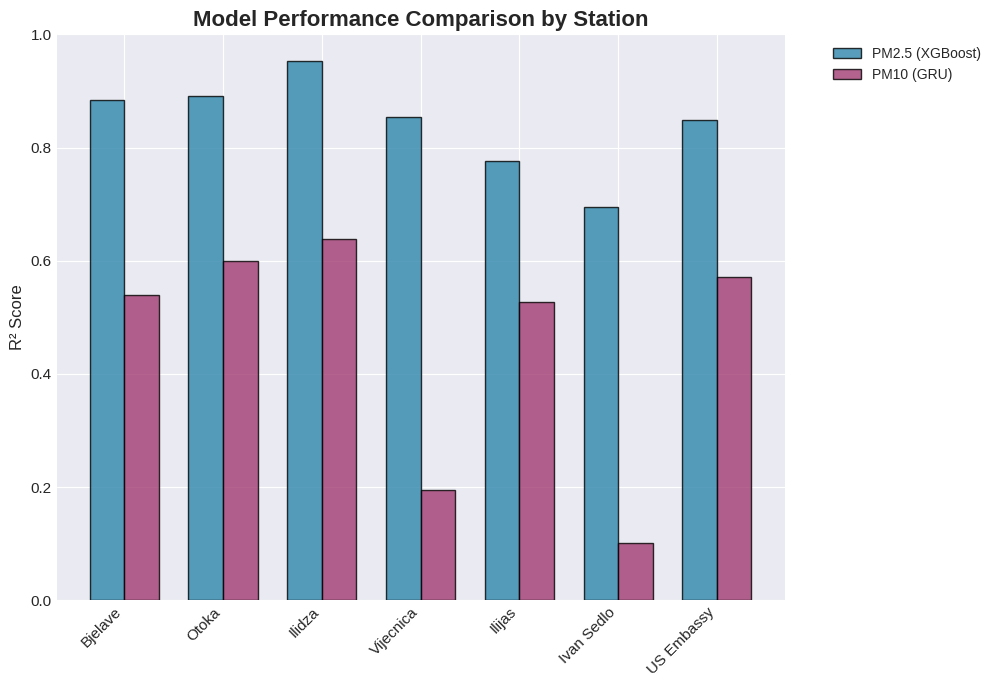

Plot 2/12: Error Heatmap...
Generated: dashboard_error_heatmap.png


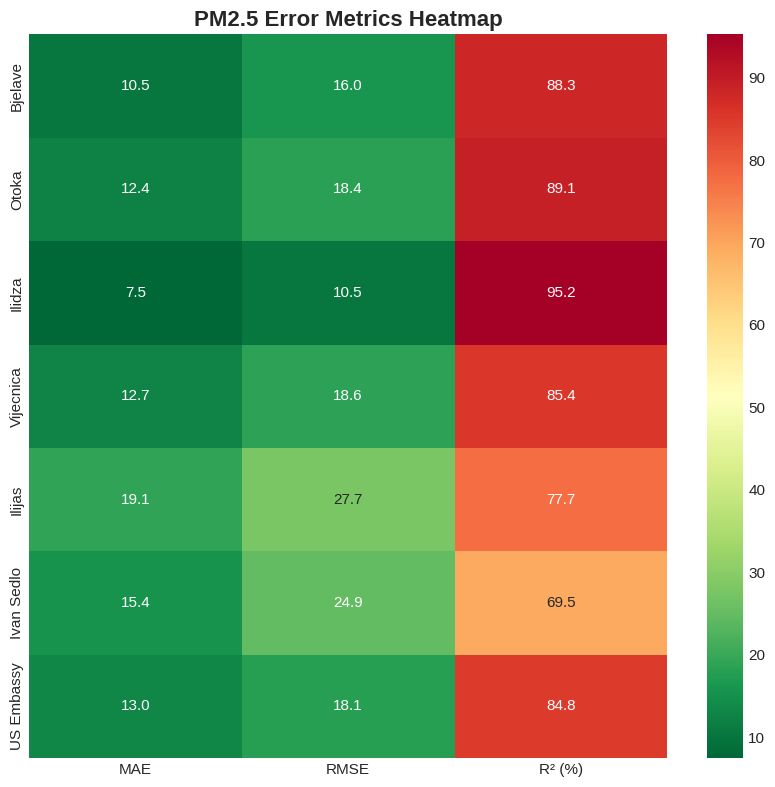

Plot 3/12: Time Series Analysis...
Generated: dashboard_best_station_ts.png


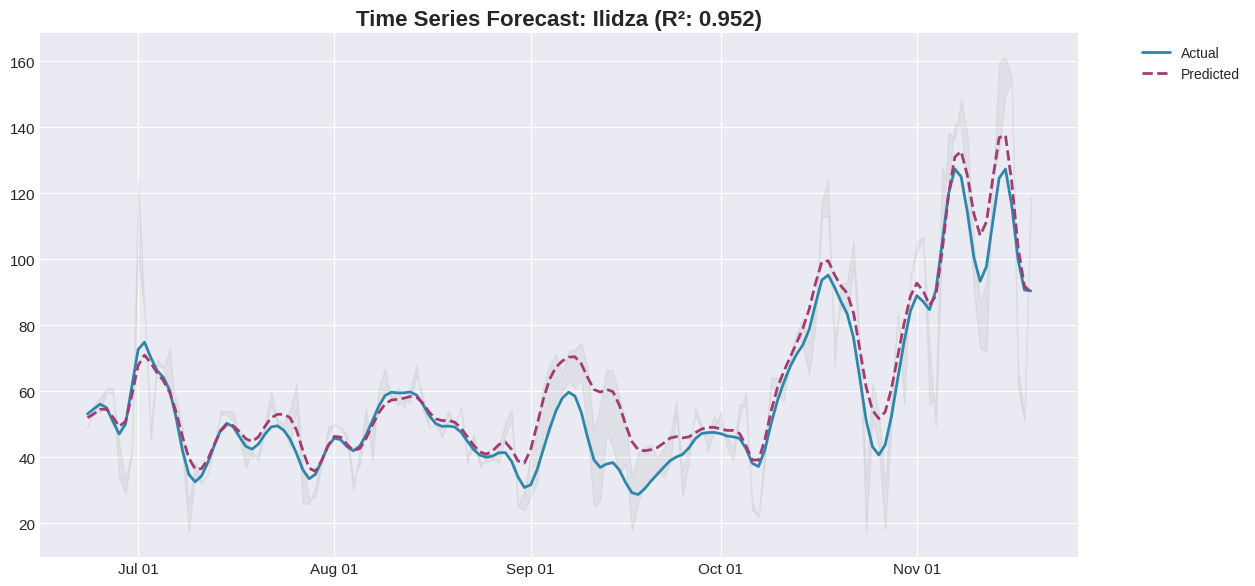

Plot 4/12: Scatter Correlation...
Generated: dashboard_scatter_plot.png


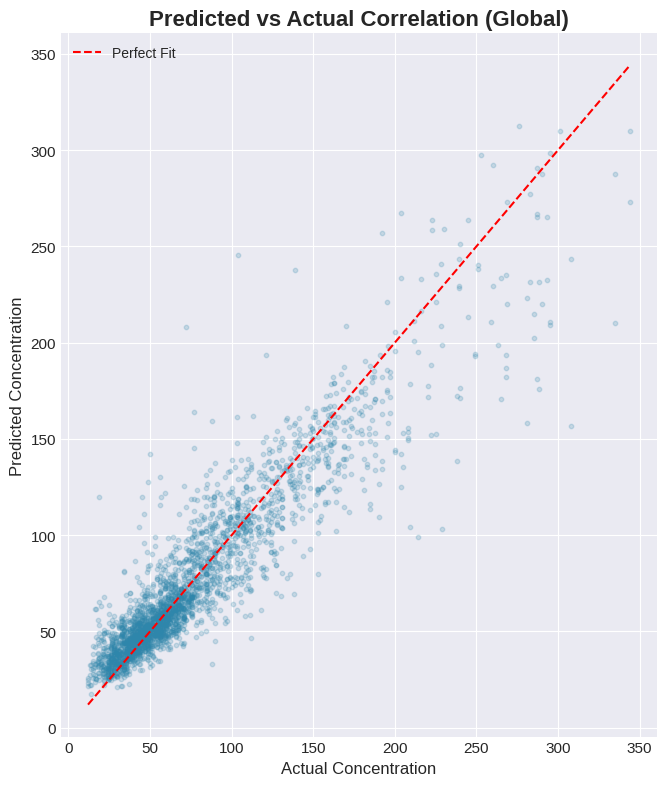

Plot 5/12: Residual Distribution...
Generated: dashboard_error_distribution.png


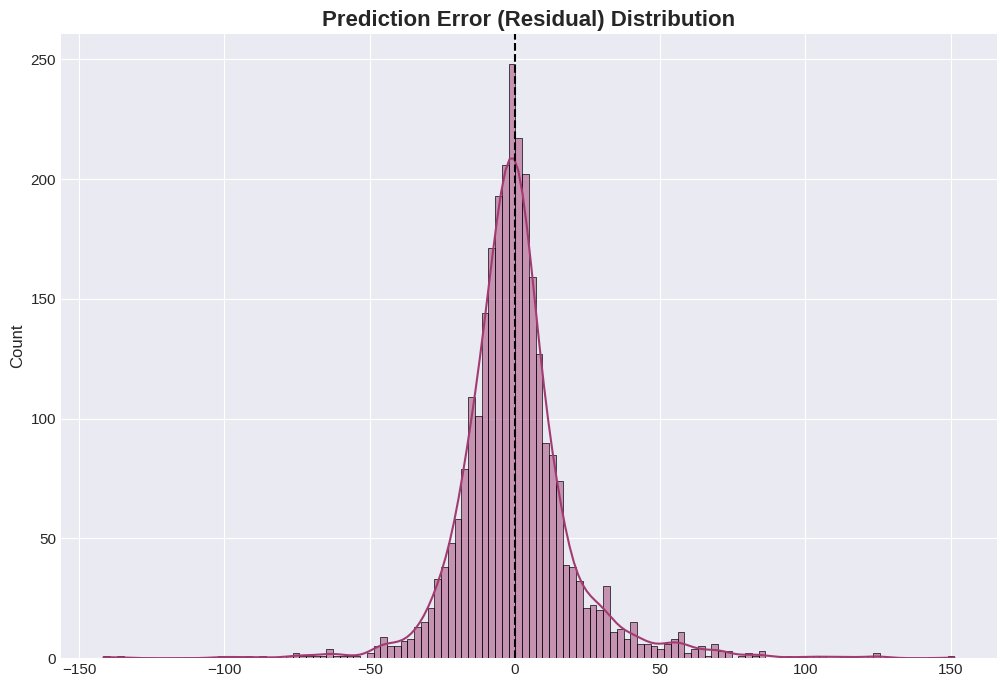

Plot 6/12: Horizon Analysis...
Generated: dashboard_horizon_analysis.png


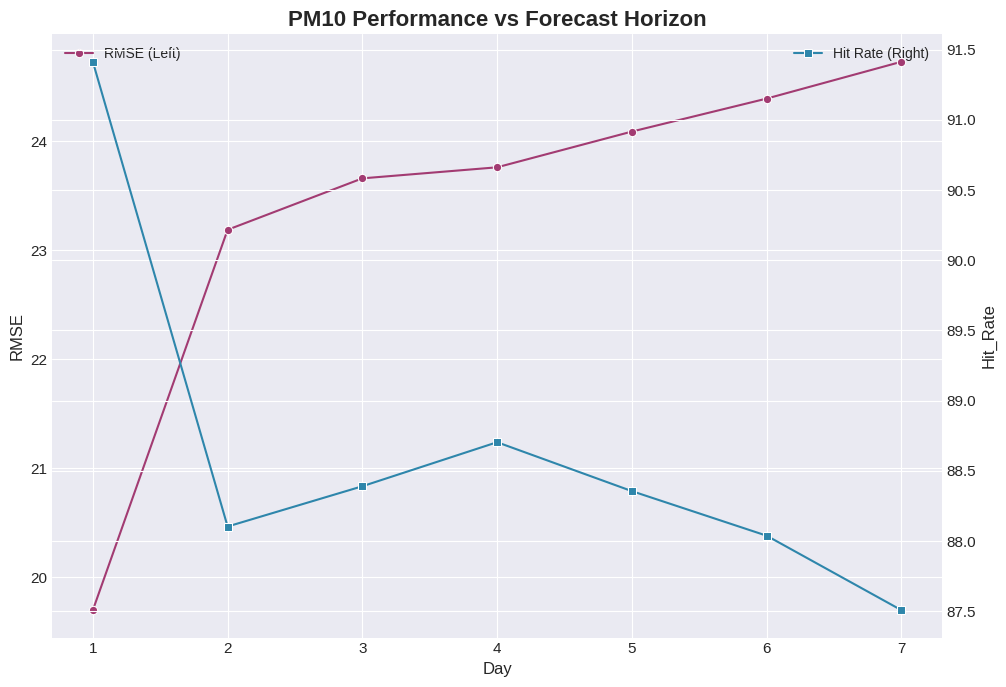

Plot 7/12: Seasonal Trends...
Generated: dashboard_seasonal_analysis.png


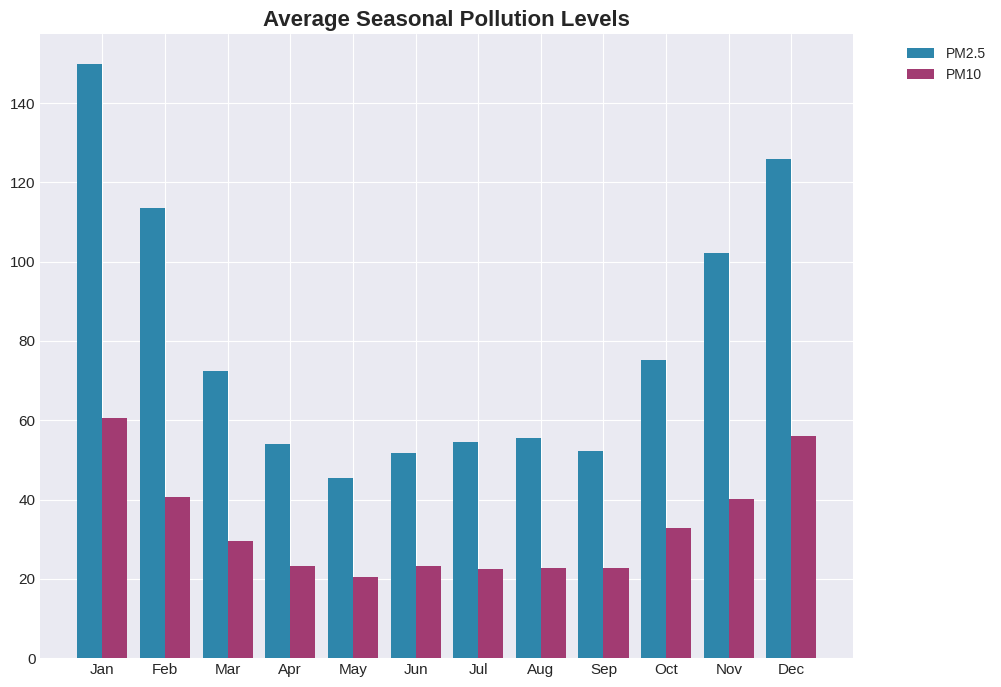

Plot 8/12: Station Ranking...
Generated: dashboard_station_ranking.png


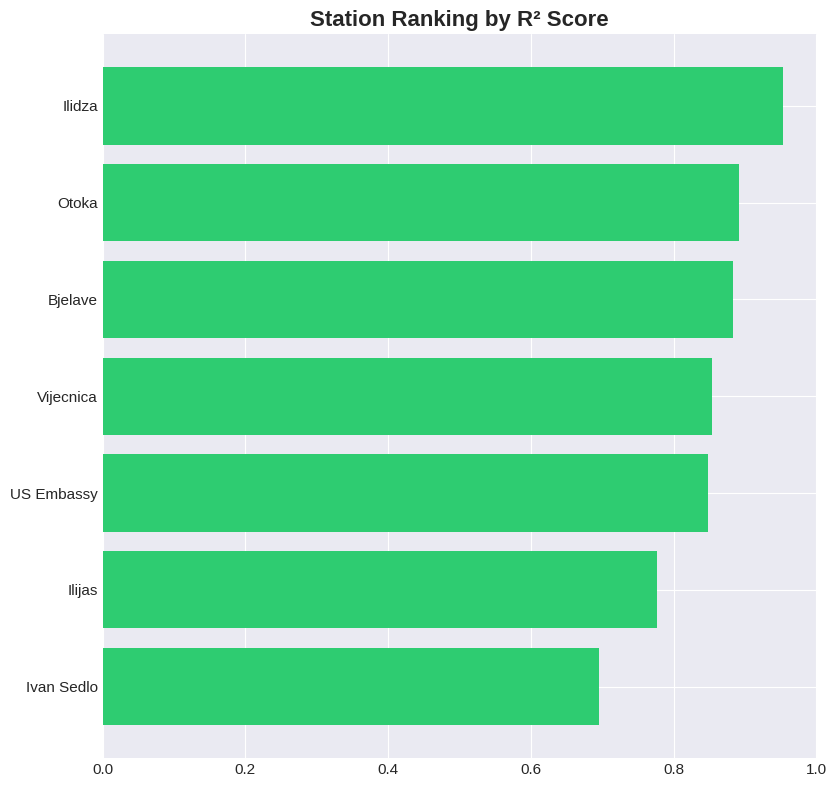

Plot 9/12: Feature Importance...
Generated: dashboard_feature_importance.png


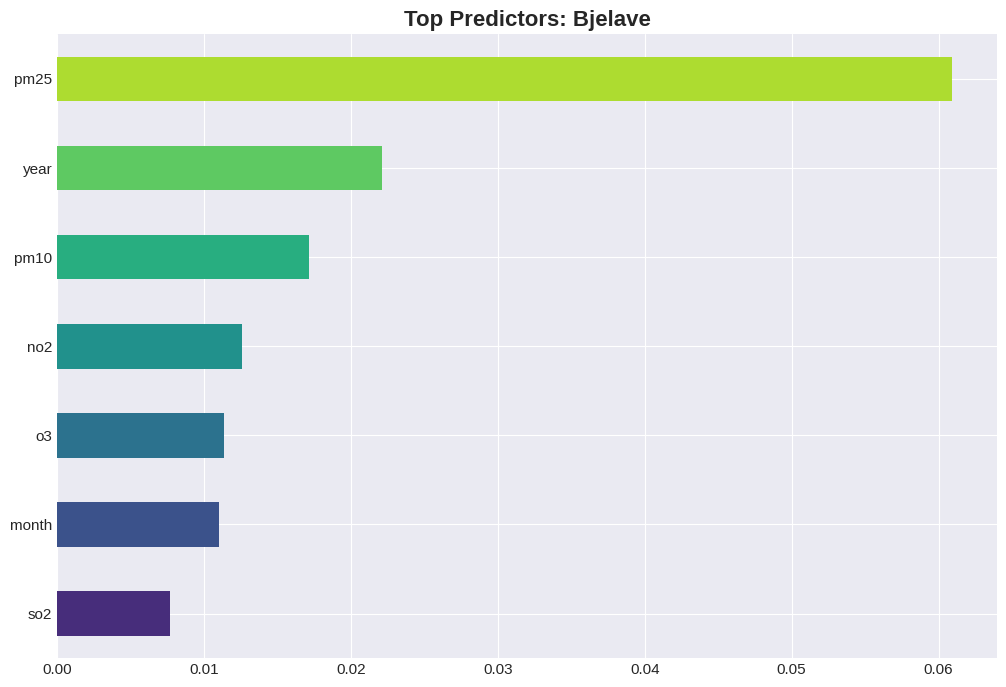

Plot 10/12: Metrics Table...
Generated: dashboard_summary_table.png


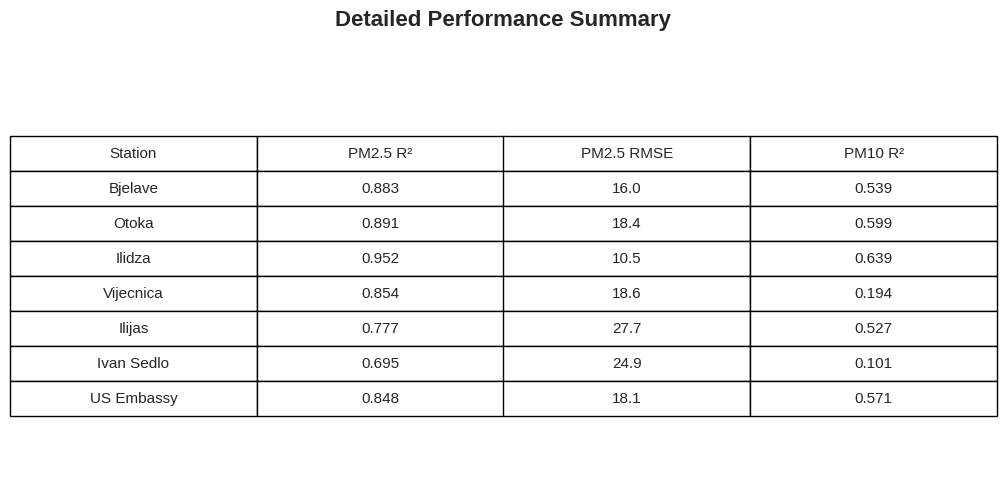


REPORT GENERATION COMPLETE


In [40]:
from scipy.ndimage import gaussian_filter1d

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams.update({
    'figure.figsize': (12, 7),
    'font.size': 11,
    'axes.titlesize': 16,
    'axes.titleweight': 'bold',
    'axes.labelsize': 12,
    'legend.fontsize': 10,
    'figure.facecolor': 'white'
})

def finalize_and_save(title):
    """Formats, saves, and closes the current figure."""
    plt.tight_layout(rect=[0, 0, 0.85, 1]) # Make room for legends on the right
    filename = f"dashboard_{title.lower().replace(' ', '_')}.png"
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    print(f"Generated: {filename}")
    plt.show()
    plt.close()


# 1. PERFORMANCE COMPARISON (PM2.5 vs PM10)
print("Plot 1/12: Performance Comparison...")
plt.figure()
available_stations = [s for s in stations if s in all_station_predictions or s in all_station_predictions_pm10]

if available_stations:
    x = np.arange(len(available_stations))
    width = 0.35
    pm25_r2 = [all_station_predictions.get(s, {}).get('test_r2', 0) for s in available_stations]
    pm10_r2 = [all_station_predictions_pm10.get(s, {}).get('test_r2', 0) for s in available_stations]

    plt.bar(x - width/2, pm25_r2, width, label='PM2.5 (XGBoost)', color='#2E86AB', alpha=0.8, edgecolor='black')
    plt.bar(x + width/2, pm10_r2, width, label='PM10 (GRU)', color='#A23B72', alpha=0.8, edgecolor='black')

    plt.xticks(x, available_stations, rotation=45, ha='right')
    plt.ylabel('R² Score')
    plt.title('Model Performance Comparison by Station')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    finalize_and_save("performance_comparison")

# 2. ERROR METRICS HEATMAP
print("Plot 2/12: Error Heatmap...")
plt.figure(figsize=(10, 8))
heatmap_data = []
station_labels = []
for station in stations:
    if station in all_station_predictions:
        station_labels.append(station)
        heatmap_data.append([
            all_station_predictions[station]['test_mae'],
            all_station_predictions[station]['test_rmse'],
            all_station_predictions[station]['test_r2'] * 100
        ])

if heatmap_data:
    sns.heatmap(pd.DataFrame(heatmap_data, index=station_labels, columns=['MAE', 'RMSE', 'R² (%)']),
                annot=True, fmt=".1f", cmap='RdYlGn_r')
    plt.title('PM2.5 Error Metrics Heatmap')
    finalize_and_save("error_heatmap")

# 3. TIME SERIES (Best Station)
print("Plot 3/12: Time Series Analysis...")
best_station = max(all_station_predictions.keys(), key=lambda s: all_station_predictions[s]['test_r2'], default=None)
if best_station:
    plt.figure(figsize=(15, 6))
    data = all_station_predictions[best_station]
    dates = pd.to_datetime(data['test_dates'])
    n = min(150, len(dates))

    plt.plot(dates[-n:], gaussian_filter1d(data['test_true'][-n:], 1.5), label='Actual', color='#2E86AB', lw=2)
    plt.plot(dates[-n:], gaussian_filter1d(data['test_predictions'][-n:], 1.5), label='Predicted', color='#A23B72', lw=2, ls='--')
    plt.fill_between(dates[-n:], data['test_true'][-n:], data['test_predictions'][-n:], alpha=0.1, color='gray')

    plt.title(f'Time Series Forecast: {best_station} (R²: {data["test_r2"]:.3f})')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    finalize_and_save("best_station_ts")

# 4. SCATTER PLOT (All Stations)
print("Plot 4/12: Scatter Correlation...")
plt.figure(figsize=(8, 8))
all_act = [val for s in all_station_predictions.values() for val in s['test_true']]
all_pre = [val for s in all_station_predictions.values() for val in s['test_predictions']]

if all_act:
    plt.scatter(all_act, all_pre, alpha=0.2, color='#2E86AB', s=10)
    plt.plot([min(all_act), max(all_act)], [min(all_act), max(all_act)], 'r--', label='Perfect Fit')
    plt.title('Predicted vs Actual Correlation (Global)')
    plt.xlabel('Actual Concentration')
    plt.ylabel('Predicted Concentration')
    plt.legend(loc='upper left')
    finalize_and_save("scatter_plot")

# 5. ERROR DISTRIBUTION
print("Plot 5/12: Residual Distribution...")
plt.figure()
resids = np.array(all_act) - np.array(all_pre)
sns.histplot(resids, kde=True, color='#A23B72')
plt.axvline(0, color='black', ls='--')
plt.title('Prediction Error (Residual) Distribution')
finalize_and_save("error_distribution")

# 6. FORECAST HORIZON (PM10 Audit)
print("Plot 6/12: Horizon Analysis...")
audit_files = [f for f in os.listdir('.') if f.startswith('pm10_audit_') and f.endswith('.csv')]
if audit_files:
    plt.figure()
    combined = pd.concat([pd.read_csv(f) for f in audit_files])
    avg_m = combined.groupby('Day').mean(numeric_only=True).reset_index()

    ax = sns.lineplot(data=avg_m, x='Day', y='RMSE', marker='o', label='RMSE (Left)', color='#A23B72')
    ax2 = ax.twinx()
    sns.lineplot(data=avg_m, x='Day', y='Hit_Rate', marker='s', label='Hit Rate (Right)', color='#2E86AB', ax=ax2)

    plt.title('PM10 Performance vs Forecast Horizon')
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')
    finalize_and_save("horizon_analysis")

# 7. SEASONAL PATTERNS
print("Plot 7/12: Seasonal Trends...")
plt.figure()
df['month'] = df['date'].dt.month
m_avg = df.groupby('month').agg({'pm25': 'mean', 'pm10': 'mean'}).reset_index()
plt.bar(m_avg['month'] - 0.2, m_avg['pm25'], width=0.4, label='PM2.5', color='#2E86AB')
plt.bar(m_avg['month'] + 0.2, m_avg['pm10'], width=0.4, label='PM10', color='#A23B72')
plt.xticks(range(1, 13), ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.title('Average Seasonal Pollution Levels')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
finalize_and_save("seasonal_analysis")

# 8. STATION RANKING
print("Plot 8/12: Station Ranking...")
plt.figure(figsize=(10, 8))
ranks = pd.DataFrame([{'Stat': s, 'R2': d['test_r2']} for s, d in all_station_predictions.items()]).sort_values('R2')
plt.barh(ranks['Stat'], ranks['R2'], color='#2ecc71')
plt.title('Station Ranking by R² Score')
finalize_and_save("station_ranking")

# 9. FEATURE IMPORTANCE
print("Plot 9/12: Feature Importance...")
if stations and stations[0] in pm25_models:
    plt.figure()
    try:
        imp = pm25_models[stations[0]].feature_importances_
        # Average across lookback window
        agg_imp = np.mean(imp.reshape(-1, len(feature_cols)), axis=0)
        feat_imp = pd.Series(agg_imp, index=feature_cols).sort_values()
        feat_imp.plot(kind='barh', color=sns.color_palette("viridis", len(feature_cols)))
        plt.title(f'Top Predictors: {stations[0]}')
        finalize_and_save("feature_importance")
    except: plt.close()

# 10. SUMMARY METRICS TABLE
print("Plot 10/12: Metrics Table...")
plt.figure(figsize=(12, 5))
plt.axis('off')
t_data = [[s, f"{all_station_predictions[s]['test_r2']:.3f}", f"{all_station_predictions[s]['test_rmse']:.1f}",
           f"{all_station_predictions_pm10.get(s, {}).get('test_r2', 0):.3f}"] for s in stations[:10]] # Limit to top 10 for clarity
plt.table(cellText=t_data, colLabels=['Station', 'PM2.5 R²', 'PM2.5 RMSE', 'PM10 R²'], loc='center', cellLoc='center').scale(1, 2)
plt.title('Detailed Performance Summary', y=1.1)
finalize_and_save("summary_table")


print("\n" + "="*30 + "\nREPORT GENERATION COMPLETE\n" + "="*30)

Overall, the performance visualizations show that the models capture air quality patterns reasonably well, with clear differences between pollutants and stations. The XGBoost model performs very strongly for PM2.5 across all locations, achieving high R² values and closely matching the observed measurements over time. The predicted PM2.5 series follows both daily variations and major pollution peaks, with only slight smoothing during extreme events. In contrast, the GRU model for PM10 shows more mixed results, performing moderately well at some stations but struggling at others, such as Vijećnica and Ivan Sedlo, where predictions are less accurate. The error distribution is centered around zero, indicating that the predictions are generally unbiased, although larger errors still occur during high pollution episodes. Overall, the results suggest that PM2.5 can be modeled more reliably with the current approach, while PM10 prediction would benefit from further model improvements and additional input features.